## Mel Spectrogram with Raw Acceleration Overlay

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import pandas as pd
import json
import librosa.display

# Load the JSON file
file_path = '../datasets/osdb_3min_allSeizures.json'  # Replace with your JSON file path
with open(file_path, 'r') as file:
    raw_json = json.load(file)
    
# Flatten the JSON and extract relevant fields
flattened_data = []

for attribute in raw_json:
    user_id = attribute.get('userId', None)
    datapoints = attribute.get('datapoints', [])

    for point in datapoints:
        event_id = point.get('eventId', None)
        hr = point.get('hr', [])
        o2Sat = point.get('o2Sat', [])
        rawData = point.get('rawData', [])
        rawData3D = point.get('rawData3D', [])
        # Append every datapoint as a row
        flattened_data.append({
            'eventId': event_id,
            'userId': user_id,
            'hr': hr,
            'o2Sat': o2Sat,
            'rawData': rawData,
            'rawData3D': rawData3D,

        })
        
# Create a DataFrame
df_sensordata = pd.DataFrame(flattened_data)
df_sensordata.to_csv('sensordata.csv', index=False)

# Display the DataFrame
df_sensordata.head()

,eventId,userId,hr,o2Sat,rawData,rawData3D
0,407,39,67,-1,"[1496, 1480, 1500, 1492, 1496, 1484, 1500, 149...",[]
1,407,39,67,-1,"[1492, 1508, 1496, 1476, 1484, 1476, 1496, 150...",[]
2,407,39,68,-1,"[1488, 1496, 1484, 1492, 1492, 1508, 1504, 148...",[]
3,407,39,69,-1,"[1488, 1476, 1480, 1504, 1496, 1508, 1484, 148...",[]
4,407,39,69,-1,"[1504, 1488, 1504, 1492, 1484, 1500, 1496, 149...",[]


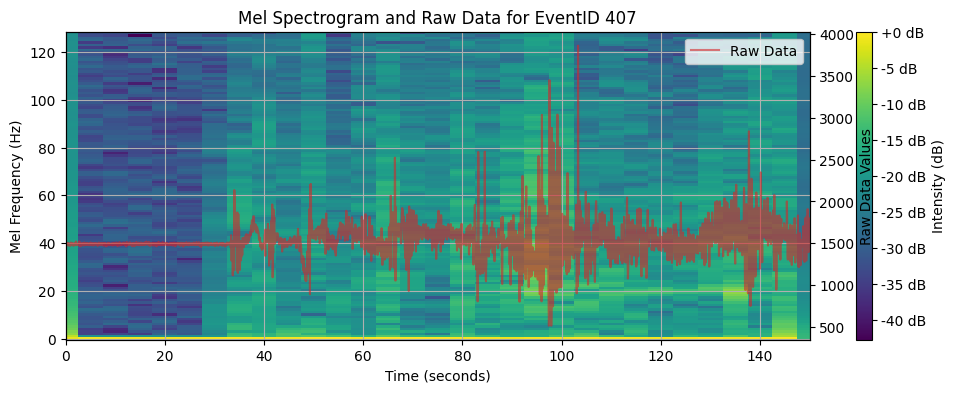

In [11]:
# Filter rows for eventId 407
event_id = 407
filtered_data = df_sensordata[df_sensordata['eventId'] == event_id]

# Total number of rows for the event
num_rows = len(filtered_data)

# Calculate total time (in seconds)
total_time = num_rows * 5

# Generate x-axis points for each rawData point
time_points = np.linspace(0, total_time, num_rows * 125)  # 125 values per row

# Flatten the rawData column for plotting and Mel Spectrogram
raw_data = np.hstack(filtered_data['rawData'].values)

# Sampling frequency (125 Hz based on the data)
sampling_rate = 125  # in Hz

# Apply Short-Time Fourier Transform (STFT) to the raw data
f, t, Zxx = signal.stft(raw_data, fs=sampling_rate, nperseg=256)

# Apply Mel filter bank to the magnitude of the STFT to create a Mel Spectrogram
mel_spectrogram = librosa.feature.melspectrogram(S=np.abs(Zxx), sr=sampling_rate, n_mels=128)

# Convert to logarithmic scale (dB) for better visualization
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

# Normalize the x-axis of the spectrogram to match total_time
# Scale t to match the actual total time
spectrogram_time = np.linspace(0, total_time, log_mel_spectrogram.shape[1])

# Plot the Mel Spectrogram and Raw Data together
fig, ax1 = plt.subplots(figsize=(12, 4))

# Plot the Mel Spectrogram
mappable = ax1.pcolormesh(
    spectrogram_time, 
    np.linspace(0, mel_spectrogram.shape[0], mel_spectrogram.shape[0]), 
    log_mel_spectrogram, 
    shading='auto', 
    cmap='viridis'
)
plt.colorbar(mappable, format='%+2.0f dB', ax=ax1, label="Intensity (dB)")
ax1.set_title(f'Mel Spectrogram and Raw Data for EventID {event_id}')
ax1.set_xlabel("Time (seconds)")
ax1.set_ylabel("Mel Frequency (Hz)", color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True)

# Create a second y-axis for the raw acceleration data
ax2 = ax1.twinx()

# Plot the raw acceleration data
ax2.plot(time_points, raw_data, color='tab:red', alpha=0.6, label='Raw Data')
ax2.set_ylabel("Raw Data Values", color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax2.legend(loc='upper right')

# Ensure x-axis for both plots matches the total duration
ax1.set_xlim(0, total_time)
ax2.set_xlim(0, total_time)

# Display the combined plot
plt.show()


# 📊 **Mel Spectrogram and Raw Data Visualization**

## Overview
This notebook demonstrates how to process and visualize raw sensor data by applying **Short-Time Fourier Transform (STFT)** and generating a **Mel Spectrogram**. The **Mel Spectrogram** is then combined with the corresponding **raw sensor data** (acceleration vector magnitude signal) in the time domain, enabling a detailed comparison of patterns in both the frequency and time domains.

---

## 📝 **Workflow**

### 1. **📂 Loading and Flattening Data**
   - The data is loaded from a **JSON** file, which contains various sensor measurements.
   - Relevant fields such as **`userId`**, **`eventId`**, **`hr`** (heart rate), **`o2Sat`** (oxygen saturation), **`rawData`**, and **`rawData3D`** are extracted from the raw JSON data.
   - Each entry in the dataset represents a specific event captured by the sensor system. These are then flattened to prepare the data for analysis.

### 2. **🔄 Creating the DataFrame**
   - A **Pandas DataFrame** is created to store the flattened data in a structured, tabular format.
   - The DataFrame is saved as a CSV file (`sensordata.csv`) for easy access and future processing.

### 3. **🔍 Filtering for Specific Event**
   - The dataset is filtered to isolate data for a specific event using the **`eventId`** (in this case, **`eventId 407`**).
   - This helps focus the analysis on a specific event, extracting all corresponding data points from the original dataset.

### 4. **⏱️ Generating Time Points**
   - A **time axis** is generated based on the total number of data points for the filtered event.
   - Each point in the raw data corresponds to **5 seconds** of sensor data, and the total time is calculated based on the number of data points multiplied by this time interval.

### 5. **🔄 Applying Short-Time Fourier Transform (STFT)**
   - The **Short-Time Fourier Transform (STFT)** is applied to the **raw data** to capture its frequency components over time.
   - This transformation provides insight into the signal's frequency content at each time step.

### 6. **🎚️ Creating Mel Spectrogram**
   - A **Mel Spectrogram** is computed from the magnitude of the **STFT**. The Mel scale is used to make the spectrogram more perceptually relevant to human hearing.
   - This step transforms the frequency information into a logarithmic scale for better visualization.

### 7. **📈 Plotting Mel Spectrogram and Raw Data**
   - The **Mel Spectrogram** is visualized using a color map, with the intensity represented in **dB (decibels)**.
   - The **raw sensor data** (acceleration vector magnitude) is overlaid on the same plot using a secondary y-axis.
   - Both visualizations share the same x-axis, which represents the total duration of the event in seconds.

### 8. **📊 Final Output**
   - The final plot shows both the **Mel Spectrogram** and **raw sensor data** over time, enabling a detailed comparison of frequency and time-domain patterns.
   - The visualization aids in identifying frequency changes and event-related trends in the sensor data.

---

## 📍 **Key Features**
- **🔬 STFT and Mel Spectrogram** provide deep insights into the frequency content of the sensor data.
- **📊 Combined Visualization** helps visualize both time and frequency domains simultaneously.
- **🔍 Filtering for specific events** allows for focused analysis of individual events in the dataset.

---

## 👤 **Author**  
Developed for the Open Seizure Database by **Jamie Pordoy**.
